<a href="https://colab.research.google.com/github/stanbuklovskyi/Over-and-underperformce-detection-in-Chipotle-sales/blob/main/Over_and_underperformce_detection_in_Chipotle_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, let's start with import of libraries and datafile from GitHub

In [ ]:
from xlrd import xlsx
# import Chipotle clean data 
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.spatial import ConvexHull
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np
# path = "/content/drive/MyDrive/chipotle_clean.xlsx" # local computer path (change to github?)
path = "https://github.com/stanbuklovskyi/Chipotle_stores_project/blob/4570a8fce252b3bd222bcad409a47b76450c24e4/chipotle_clean.xlsx?raw=true"
sheet_name = "chipotle_stores"
dataset = pd.read_excel(path, sheet_name)

There is a library that is not present in Colab. Let's install it.
Plotly is a great library for visualization. I will use it for 3D scatter plot and a plot of geo coordinates on the map. 

In [ ]:
!pip install plotly # install library for geoplot
import plotly.express as px

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


First, let's take a look at the imported dataset head, tail and shape to make sure everything was imported correctly.

In [ ]:
# show dataset head
dataset.head()

,state,location,address,latitude,longitude,Sales
0,Alabama,Auburn,"346 W Magnolia Ave Auburn, AL 36832 US",32.606813,-85.487328,51649.0
1,Alabama,Birmingham,"300 20th St S Birmingham, AL 35233 US",33.509721,-86.802756,63973.0
2,Alabama,Birmingham,"3220 Morrow Rd Birmingham, AL 35235 US",33.595581,-86.647437,46395.0
3,Alabama,Birmingham,"4719 Highway 280 Birmingham, AL 35242 US",33.422582,-86.698279,43945.0
4,Alabama,Cullman,"1821 Cherokee Ave SW Cullman, AL 35055 US",34.154134,-86.841220,36725.0


In [ ]:
dataset.tail()

,state,location,address,latitude,longitude,Sales
2624,Wisconsin,Pleasant Prairie,"9370 76th St # B Pleasant Prairie, WI 53158 US",42.565892,-87.921048,53164.0
2625,Wisconsin,Wauwatosa,"2711 N Mayfair Rd Ste A Wauwatosa, WI 53222 US",43.067723,-88.048222,51327.0
2626,North Dakota,Fargo,"1204 19th Ave N Fargo, ND 58102 US",46.904247,-96.796618,53126.0
2627,North Dakota,Fargo,"1680 45th St S Fargo, ND 58103 US",46.855337,-96.861416,40765.0
2628,Wyoming,Cheyenne,"1508 Dell Range Blvd Cheyenne, WY 82009 US",41.160718,-104.805699,52962.0


In [ ]:
dataset.shape

(2629, 6)

Stores sales data plays a key role in this project. Since real sales data from Chipotle is private, we will generate artificial sales data (normal distribution). Generation of the data in this case does not change the algorithm in principal. If the real data is present it can be imported in a way described above.

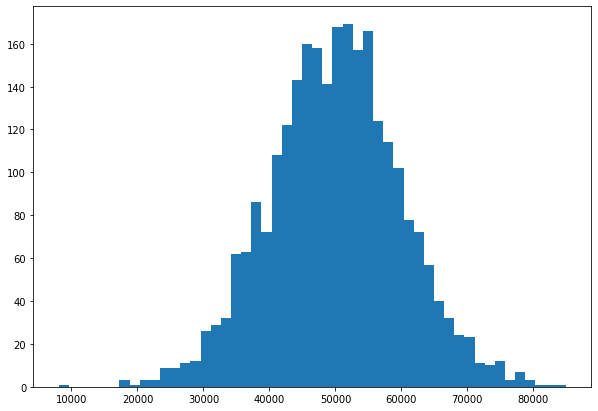

In [ ]:
# generate normal distribution data for sales (in thousands of $, 50k = 50 M)
sales_mean = 50000
sales_std = 10000

sales = np.random.normal(sales_mean, sales_std, dataset.shape[0])
sales = np.round_(sales, decimals=0) # round results to integer
# sales

# plot data histogram
bins_n = 50

fig, axs = plt.subplots(1,1, figsize = (10,7))
axs.hist(sales, bins = bins_n)
plt.show()


In [ ]:
# append sales and look at the final dataset
dataset['Sales'] = sales
dataset.head()

,state,location,address,latitude,longitude,Sales
0,Alabama,Auburn,"346 W Magnolia Ave Auburn, AL 36832 US",32.606813,-85.487328,51649.0
1,Alabama,Birmingham,"300 20th St S Birmingham, AL 35233 US",33.509721,-86.802756,63973.0
2,Alabama,Birmingham,"3220 Morrow Rd Birmingham, AL 35235 US",33.595581,-86.647437,46395.0
3,Alabama,Birmingham,"4719 Highway 280 Birmingham, AL 35242 US",33.422582,-86.698279,43945.0
4,Alabama,Cullman,"1821 Cherokee Ave SW Cullman, AL 35055 US",34.154134,-86.841220,36725.0


In [ ]:
# convert features to features numpy array for scaling
features = dataset[['latitude', 'longitude', 'Sales']].to_numpy()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# show data
scaled_features[:5]

array([[-1.03390345,  0.42248947,  0.16852481],
       [-0.84374483,  0.34312955,  1.40822001],
       [-0.82566215,  0.35249995, -0.3599853 ],
       [-0.86209697,  0.34943261, -0.60643558],
       [-0.70802727,  0.34080898, -1.33270947]])

In [ ]:
# Simple elbow method to determine optimal K for Kmeans clustering
k = [*range(2,50)] # range of values for k to try
inertias = [] # list to keep inertias for elbow method

for i in k:
    km = KMeans(n_clusters=i, max_iter=1000)
    km.fit(scaled_features)
    inertias.append(km.inertia_)

# plt.plot(k, inertias, 'o-')
# plt.xlabel("Value of k")
# plt.ylabel("WSS")
# plt.title('Elbow Method')
# plt.show()


Text(0.5, 1.0, 'Elbow Method')

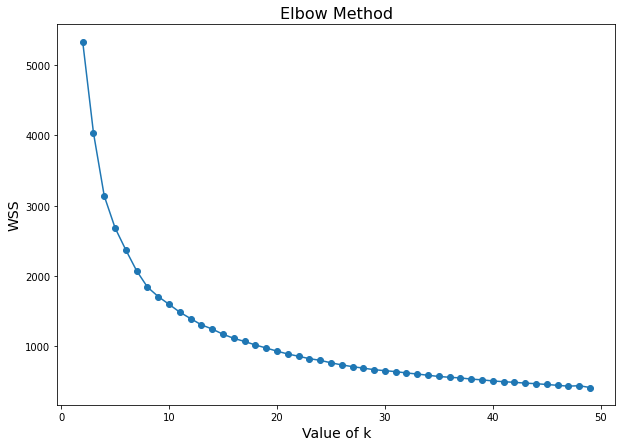

In [ ]:
# plot result
fig, axs = plt.subplots(1,1, figsize=(10,7))
axs.plot(k, inertias, 'o-')

font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size' : 14,
}
font2 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size' : 16,
}
axs.set_xlabel("Value of k",font1)
axs.set_ylabel("WSS",font1)
axs.set_title('Elbow Method',font2)

In [ ]:
# Silhouette coeff.
from sklearn import metrics
score = []

for n in k:
    k_means = KMeans(n_clusters=n).fit(scaled_features)
    score.append(metrics.silhouette_score(scaled_features, k_means.labels_))

Text(0.5, 1.0, 'Silhouette method')

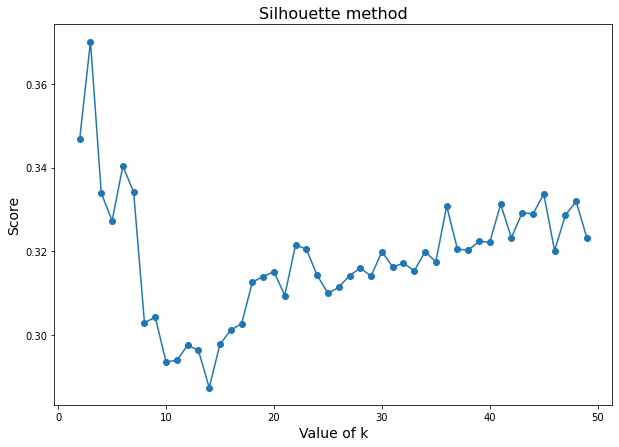

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(10,7))
axs.plot(k, score, 'o-')

axs.set_xlabel("Value of k",font1)
axs.set_ylabel("Score",font1)
axs.set_title('Silhouette method',font2)

Silhouette method shows **K=3** as the optimal value for grouping. We will go with K=3 - more conservative value from the two

In [ ]:
# fit, predict optimal model
k_means = KMeans(n_clusters=3).fit(scaled_features)
k_labels = k_means.predict(scaled_features)

In [ ]:
# make a deep copy of the "dataset" dataframe for results
import copy
results = pd.DataFrame(columns = dataset.columns, data = copy.deepcopy(dataset.values))
# del results['group']

# add k means labels to the dataframe
results['k_means'] = k_labels
results.head()

,state,location,address,latitude,longitude,Sales,k_means
0,Alabama,Auburn,"346 W Magnolia Ave Auburn, AL 36832 US",32.606813,-85.487328,51649.0,2
1,Alabama,Birmingham,"300 20th St S Birmingham, AL 35233 US",33.509721,-86.802756,63973.0,2
2,Alabama,Birmingham,"3220 Morrow Rd Birmingham, AL 35235 US",33.595581,-86.647437,46395.0,2
3,Alabama,Birmingham,"4719 Highway 280 Birmingham, AL 35242 US",33.422582,-86.698279,43945.0,2
4,Alabama,Cullman,"1821 Cherokee Ave SW Cullman, AL 35055 US",34.154134,-86.84122,36725.0,2


In [ ]:
# preprocess the data for future outlier detection

# reshape
x = results.latitude.to_numpy().reshape(-1,1)
y = results.longitude.to_numpy().reshape(-1,1)
z = results.Sales.to_numpy().reshape(-1,1)

# scale
scaler = StandardScaler()
scaled_x = scaler.fit_transform(x)
scaled_y = scaler.fit_transform(y)
scaled_z = scaler.fit_transform(z)


In [ ]:
# 3D plot by Plotly
import plotly.express as plx
fig = plx.scatter_3d(results, x='latitude', y='longitude', z='Sales', color='k_means',width=700)
fig.show()

Looks like the plot can be built in 2d




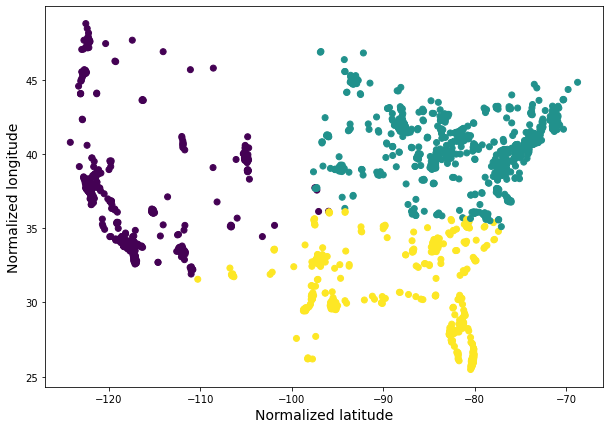

In [ ]:
# scatter in 2D
fig, axs = plt.subplots(1,1,figsize=(10,7))
axs.scatter(results.longitude,results.latitude, c=results.k_means)
axs.set_xlabel("Normalized latitude",font1)
axs.set_ylabel("Normalized longitude",font1)

plt.show()

In [ ]:
# plot on a map
fig = px.scatter_geo(dataset,lat=results.latitude,lon=results.longitude, color=results.k_means)
fig.update_layout(title = 'Chipotle in the US', title_x=0.5)
fig.show()

In [ ]:
# oulier detection for whole data (local outlier factor)
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=20)

clf.fit_predict(scaled_z)
outlier_result = clf.negative_outlier_factor_

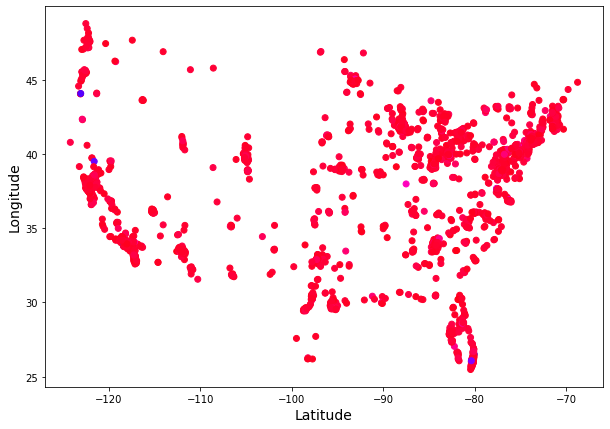

In [ ]:
# plot local outlier factor for all data values
fig, axs = plt.subplots(1,1,figsize=(10,7))
axs.scatter(results.longitude,results.latitude, c=outlier_result, cmap='hsv')
axs.set_xlabel("Latitude",font1)
axs.set_ylabel("Longitude",font1)

plt.show()

In [ ]:
# now outliers in each group
# need to save indeces to construct data back
group1 = results[results.k_means == 0]
group2 = results[results.k_means == 1]
group3 = results[results.k_means == 2]

# outliers group #1
clf_group1 = LocalOutlierFactor(n_neighbors=20)
clf_group1.fit_predict(group1.Sales.to_numpy().reshape(-1,1))
outlier_group1 = clf_group1.negative_outlier_factor_

# outliers group #2
clf_group2 = LocalOutlierFactor(n_neighbors=20)
clf_group2.fit_predict(group2.Sales.to_numpy().reshape(-1,1))
outlier_group2 = clf_group2.negative_outlier_factor_

# outliers group #3
clf_group3 = LocalOutlierFactor(n_neighbors=20)
clf_group3.fit_predict(group3.Sales.to_numpy().reshape(-1,1))
outlier_group3 = clf_group3.negative_outlier_factor_

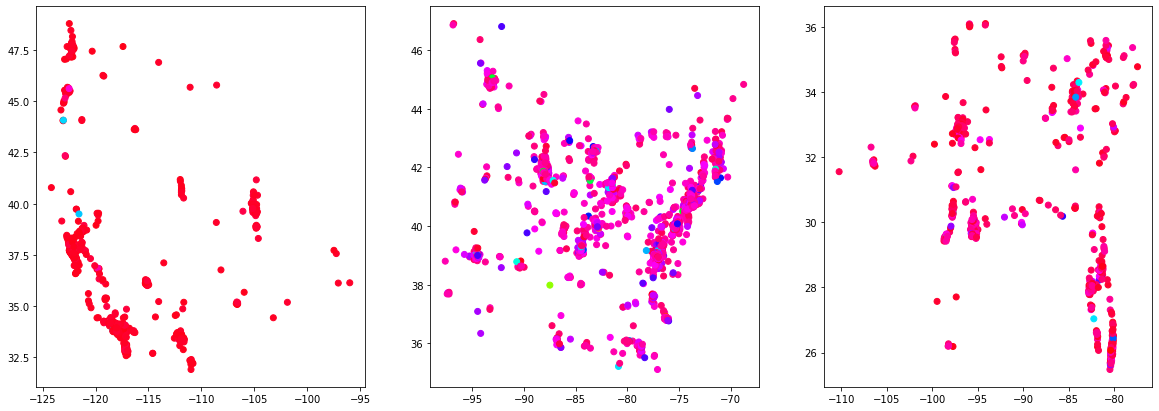

In [ ]:
# scatter plots for each group
fig, axs = plt.subplots(1,3, figsize=(20,7))
axs[0].scatter(group1.longitude, group1.latitude, c=outlier_group1, cmap='hsv')
axs[1].scatter(group2.longitude, group2.latitude, c=outlier_group2, cmap='hsv')
axs[2].scatter(group3.longitude, group3.latitude, c=outlier_group3, cmap='hsv')
plt.show()

In [ ]:
# append resulting outlier coefficients to groups 
group1['outlier_f'] = outlier_group1
group2['outlier_f'] = outlier_group2
group3['outlier_f'] = outlier_group3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [ ]:
# concat and sort resutls
final_result = pd.concat([group1, group2, group3], axis=0)
final_result.iloc[:,0]

15      Arizona
16      Arizona
17      Arizona
18      Arizona
19      Arizona
         ...   
2411      Texas
2412      Texas
2413      Texas
2414      Texas
2415      Texas
Name: state, Length: 2629, dtype: object

In [ ]:
# plot on a map
fig = px.scatter_geo(dataset,lat=final_result.latitude,lon=final_result.longitude, color=final_result.outlier_f)
fig.update_layout(title = 'Chipotle in the US', title_x=0.5)
fig.show()

In [ ]:
final_result.head()

,state,location,address,latitude,longitude,Sales,k_means,outlier_f
15,Arizona,Avondale,"9925 W McDowell Rd Ste 101 Avondale, AZ 85392 US",33.464377,-112.273194,56250.0,0,-0.997418
16,Arizona,Buckeye,"944 S Watson Rd Buckeye, AZ 85326 US",33.438308,-112.558304,50123.0,0,-1.008862
17,Arizona,Casa Grande,"1775 E Florence Blvd Ste 1 Casa Grande, AZ 851...",32.87913,-111.711235,52123.0,0,-0.974125
18,Arizona,Cave Creek,"5355 E Carefree Hwy Bldg E Cave Creek, AZ 8533...",33.799146,-111.966084,34643.0,0,-1.030134
19,Arizona,Chandler,"2895 S Alma School Rd Ste 1 Chandler, AZ 85286 US",33.263922,-111.857261,48917.0,0,-1.000674


In [ ]:
# sort values to get the order of outlier values
sorted_final_result = final_result.sort_values(by='outlier_f')
sorted_final_result = sorted_final_result.reset_index(drop=True)
sorted_final_result.head()

,state,location,address,latitude,longitude,Sales,k_means,outlier_f
0,California,Cerritos,"459 Los Cerritos Mall Cerritos, CA 90703 US",33.8619,-118.092552,8042.0,0,-6.450455
1,California,Torrance,"21300 Hawthorne Blvd Ste A Torrance, CA 90503 US",33.834988,-118.352805,84927.0,0,-3.550808
2,Oregon,Springfield,"2860 Gateway St Ste MT200 Springfield, OR 9747...",44.07341,-123.043159,18541.0,0,-3.507725
3,California,Oroville,"325 Oroville Dam Blvd Suite E1 Oroville, CA 95...",39.49757,-121.572344,18758.0,0,-3.450174
4,Colorado,Federal Heights,"10320 Federal Blvd Unit 100 Federal Heights, C...",39.884226,-105.024708,81193.0,0,-2.723650


In [ ]:
sorted_final_result.tail()

,state,location,address,latitude,longitude,Sales,k_means,outlier_f
2624,New Jersey,Paramus,"81 E State Rt 4 Ste 101 Paramus, NJ 07652 US",40.91929,-74.064841,55338.0,1,-0.939595
2625,New York,Bay Shore,"1675 Sunrise Hwy Bay Shore, NY 11706 US",40.736432,-73.24763,55362.0,1,-0.937784
2626,Illinois,Romeoville,"253 S Weber Road Romeoville, IL 60446 US",41.616326,-88.122743,55343.0,1,-0.934442
2627,Ohio,Dayton,"6759 Miller Ln Dayton, OH 45414 US",39.845569,-84.192803,55342.0,1,-0.934442
2628,Missouri,Florissant,"2391 N Highway 67 Florissant, MO 63033 US",38.804604,-90.308598,55354.0,1,-0.933439


Finally, resulting data is now sorted by the outlier coefficient. You can download it for your convenience as xlsx of csv in the cell below

In [ ]:
# download the resulting data
from google.colab import files
# sorted_final_result.to_csv('Chipotle_result.csv') 
sorted_final_result.to_excel("Chipotle_result.xlsx")
files.download("Chipotle_result.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>